In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
plt.style.use('ggplot') 
import calendar
import quandl
import pickle
from datetime import datetime, timedelta
import re  
import psycopg2
import sys
api_key = '764-Cog1Q3xa6Rns5pmj'
quandl.ApiConfig.api_key = api_key
import sqlalchemy
from sqlalchemy.sql import select, and_, or_, not_, desc, asc
from sqlalchemy import Table, Column, Integer, DateTime, String,Float, ForeignKey
from sqlalchemy.orm import sessionmaker

In [2]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

In [3]:
def connect(user, password, db, host='localhost', port=5432):
    '''Returns a connection and a metadata object'''
    # We connect with the help of the PostgreSQL URL
    url = 'postgresql+psycopg2://{}:{}@{}:{}/{}'
    url = url.format(user, password, host, port, db)

    # The return value of create_engine() is our connection object
    con = sqlalchemy.create_engine(url, client_encoding='utf8')

    # We then bind the connection to MetaData()
    meta = sqlalchemy.MetaData(bind=con)

    return con, meta

CREATE TABLES 

In [4]:
con, meta = connect('postgres', '', 'robotdb')
    
tickers = Table('Ticker', meta,
    Column('date', DateTime, primary_key = True),
    Column('coin', String, primary_key = True),
    Column('price', Float),
    Column('volume', Float),
    Column('screen', String, primary_key = True)    
)

macd = Table('Macd', meta,
    Column('date', DateTime, primary_key = True),
    Column('coin', String, primary_key = True),
    Column('ema12', Float),
    Column('ema_26', Float),
    Column('macd_line', Float),
    Column('signal_line', Float),
    Column('histogram', Float),
    Column('screen', Integer, primary_key=True)
)

boillinger = Table('Boillinger', meta,
                       Column('date', DateTime, primary_key=True),
                       Column('coin', String, primary_key=True),
                       Column('upper_band', Float),
                       Column('lower_band', Float),
                       Column('sma20', Float),
                       Column('height', Float),
                       Column('screen', Integer, primary_key=True)
                       )

ema = Table('Ema', meta,
                Column('date', DateTime, primary_key=True),
                Column('coin', String, primary_key=True),
                Column('ema5', Float),
                Column('ema20', Float),
                Column('ema5_theta', Float),
                Column('ema20_theta', Float),
                Column('screen', Integer, primary_key=True)
                )

long_positions = Table('Long', meta,
                       Column('id_position', Integer, primary_key=True),
                       Column('coin', String, primary_key=True),
                       Column('strategy', String),
                       Column('size_position', Float),
                       Column('date_ask', DateTime),
                       Column('ask', Float),
                       Column('date_settlement', DateTime),
                       Column('settlement', Float),
                       Column('take_profit', Float),
                       Column('stop_loss', Float),
                       Column('exit_date', DateTime),
                       Column('exit_price', Float),
                       Column('log_return', Float),
                       Column('source', String),
                       Column('status', String)
                       )


mkt_trend = Table('Market_trend', meta,
                  Column('coin', String, primary_key=True),
                  Column('date', DateTime, primary_key=True),
                  Column('screen', Integer, primary_key=True),
                  Column('dif_current', Float),
                  Column('dif_base', Float),
                  Column('d_dif', Float),
                  Column('theta_current', Float),
                  Column('theta_base', Float),
                  Column('d_theta', Float),
                  Column('vote', Integer)
                  )


rsi = Table('Rsi', meta,
    Column('date', DateTime, primary_key = True),
    Column('coin', String, primary_key = True),
    Column('rsi', Float),
    Column('screen', Integer, primary_key=True)
)

balances = Table('Balance', meta,
                 Column('date', DateTime, primary_key=True),
                 Column('coin', String, primary_key=True),
                 Column('size_position', Float)
                 )


years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

In [5]:
def get_macds(coin = None, date = '2019-12-31', screen = 1):
    if coin:
        s = select([macd])\
            .where(and_(macd.c.coin == coin, macd.c.date <= date, macd.c.screen==screen))\
            .order_by(desc(macd.c.date))
    else:
         s = select([macd])\
            .where(and_(macd.c.date <= date, macd.c.screen==screen))\
            .order_by(desc(macd.c.date))
            
    rows = con.execute(s)
    macd_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not macd_df.empty:
        macd_df.columns = rows.keys()
    return macd_df

def get_tickers(coin = None, date = '2019-12-31', screen = 1):
    if coin:
        s = select([tickers])\
            .where(and_(tickers.c.coin == coin, tickers.c.date <= date, tickers.c.screen == screen))\
            .order_by(
            desc(tickers.c.date))
    else:
        s = select([tickers])\
            .where(and_(tickers.c.date <= date, tickers.c.screen == screen))\
            .order_by(
            desc(tickers.c.date))
    rows = con.execute(s)
    tickers_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not tickers_df.empty:
        tickers_df.columns = rows.keys()
    return tickers_df

def get_positions(coin=None, status='closed', date='2019-12-31'):
    if coin:
        s = select([long_positions]) \
            .where(and_(long_positions.c.coin == coin,
                        long_positions.c.date_ask <= date,
                        long_positions.c.status == status))\
            .order_by(desc(long_positions.c.date_ask))
    else:
        s = select([long_positions]) \
            .where(and_(long_positions.c.date_ask <= date,
                        long_positions.c.status == status))\
            .order_by(desc(long_positions.c.date_ask))
    rows = con.execute(s)
    long_positions_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not long_positions_df.empty:
        long_positions_df.columns = rows.keys()
    return long_positions_df

def get_emas(coin=None, date='2019-12-31', screen=1):
    if coin:
        s = select([ema])\
            .where(and_(ema.c.coin == coin, ema.c.date <= date, ema.c.screen == screen))\
            .order_by(ema.c.date.desc())
    else:
        s = select([ema])\
            .where(and_(ema.c.date <= date, ema.c.screen == screen))\
            .order_by(ema.c.date.desc())
    rows = con.execute(s)
    ema_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not ema_df.empty:
        ema_df.columns = rows.keys()
    return ema_df

def get_mkt_trend(coin=None, date='2019-12-31', screen=1):
    if coin:
        s = select([mkt_trend]).\
            where(and_(mkt_trend.c.coin == coin, mkt_trend.c.date <= date, mkt_trend.c.screen == screen)).\
            order_by(desc(mkt_trend.c.date))
    else:
        s = select([mkt_trend]).\
            where(and_(mkt_trend.c.date <= date, mkt_trend.c.screen == screen)).\
            order_by(desc(mkt_trend.c.date))
    rows = con.execute(s)
    mkt_trend_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    mkt_trend_df.columns = rows.keys()
    return mkt_trend_df

def get_balances(date, coin=None):
    if coin:
        s = select([balances]) \
            .where(and_(balances.c.coin == coin,
                        balances.c.date <= date))\
            .order_by(desc(balances.c.date))
    else:
        s = select([balances]) \
            .where(and_(balances.c.date <= date))\
            .order_by(desc(balances.c.date))
    rows = con.execute(s)
    balances_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not balances_df.empty:
        balances_df.columns = rows.keys()
    return balances_df

def get_rsis(coin=None, date='2019-12-31', screen=1):
    if coin:
        s = select([rsi]) \
            .where(and_(rsi.c.coin == coin,
                        rsi.c.date <= date,
                       rsi.c.screen == screen))\
            .order_by(desc(rsi.c.date))
    else:
        s = select([rsi]) \
            .where(and_(rsi.c.date <= date,
                        rsi.c.screen == screen
                       ))\
            .order_by(desc(rsi.c.date))
    rows = con.execute(s)
    rsi_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not rsi_df.empty:
        rsi_df.columns = rows.keys()
    return rsi_df

103.17


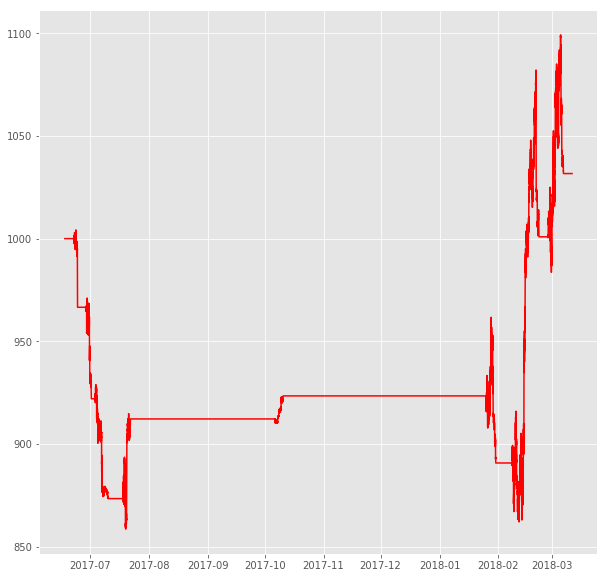

In [6]:
def plot_balance(coin, date='2019-12-31'):
    df = get_balances(date=date)
    tick = get_tickers(date = date, coin = None, screen = 0)
    merged = pd.merge(df, tick, how='left', left_on=['coin', 'date'], right_on=['coin', 'date'])
    merged.loc[merged['coin'] == 'USD', 'price'] = 1
    merged['value'] = merged['size_position'] * merged['price']
    df = merged.groupby(['date'])['value'].sum().reset_index()
    print(round((df.iloc[::-1].iloc[0].value/df.iloc[0].value),4)*100)
    fig, ax = plt.subplots()
    ax.plot(df.date.values, df.value, color = 'red')
#     plt.ylim(0, 2000)
    plt.show()
    
plot_balance('USD', '2018-03-11 18:25:00')

In [7]:
def get_signs(df):
    
    df.loc[df['dif_current'] <= -0.05, 'dif_sign_c'] = 0
    df.loc[df['dif_current'] >= 0.03, 'dif_sign_c'] = 1
    df.loc[(df['dif_current'] < 0.03) & (df['dif_current'] > -0.05), 'dif_sign_c'] = 2

    df.loc[df['dif_base'] <= -0.05, 'dif_sign_b'] = 0
    df.loc[df['dif_base'] >= 0.03, 'dif_sign_b'] = 1
    df.loc[(df['dif_base'] < 0.03) & (df['dif_base'] > -0.05), 'dif_sign_b'] = 2

    df.loc[df['d_dif'] <= -0.17, 'd_dif_sign'] = 0
    df.loc[df['d_dif'] >= 0.13, 'd_dif_sign'] = 1
    df.loc[(df['d_dif'] < 0.13) & (df['d_dif'] > -0.17), 'd_dif_sign'] = 2

    df.loc[df['theta_base'] <= -0.06, 'theta_sign_b'] = 0
    df.loc[df['theta_base'] >= 0.04, 'theta_sign_b'] = 1
    df.loc[(df['theta_base'] < 0.04) & (df['theta_base'] > -0.06), 'theta_sign_b'] = 2
    
    df.loc[df['theta_current'] <= -0.06, 'theta_sign_c'] = 0
    df.loc[df['theta_current'] >= 0.04, 'theta_sign_c'] = 1
    df.loc[(df['theta_current'] < 0.04) & (df['theta_current'] > -0.06), 'theta_sign_c'] = 2

    df.loc[df['d_theta'] <= -0.3, 'd_theta_sign'] = 0
    df.loc[df['d_theta'] >= 0.3, 'd_theta_sign'] = 1
    df.loc[(df['d_theta'] < 0.3) & (df['d_theta'] > -0.3), 'd_theta_sign'] = 2
    return df

In [8]:
def get_max_growth(tickers_filtered, base_price):
    max_growth = 0
    min_growth = 0
    for i, r in tickers_filtered.iterrows():
        g = np.log(r.price/base_price)
        max_growth = g if g > max_growth else max_growth
        min_growth = g if g < min_growth else min_growth
    return max_growth, min_growth


def get_max_min(mkt_trend_df):
    tickers_df_two = get_tickers()
    tickers_df_one = get_tickers(screen=0)
    for c in tickers_df_two.coin.unique():
        tickers_df_two_c = tickers_df_two[tickers_df_two['coin'] == c]
        tickers_df_one_c = tickers_df_one[tickers_df_one['coin'] == c]
        print(c)
        # 6 * 4h = 24h
        delta_t = 2
        for index in range(len(tickers_df_two_c)):
            base_date = tickers_df_two_c.iloc[index].date
            base_price = tickers_df_two_c.iloc[index].price
            if index >= (len(tickers_df_two_c)-delta_t):
                break
            last_date = tickers_df_two_c.iloc[(index+delta_t)].date
            t = tickers_df_one_c[(tickers_df_one_c['date'] >= base_date) & (tickers_df_one_c['date'] < last_date)]
            max_growth, min_growth = get_max_growth(t, base_price)
            tickers_df_two.loc[(tickers_df_two['date'] == base_date) & 
                               (tickers_df_two['coin'] == c), 'max_growth'] = max_growth
            tickers_df_two.loc[(tickers_df_two['date'] == base_date) & 
                               (tickers_df_two['coin'] == c), 'min_growth'] = min_growth
    
    tickers_df_two = tickers_df_two.dropna()
    return tickers_df_two

In [9]:
def manipulate_mkt_data():
    mkt_trend_df = get_mkt_trend()
    tickers_df_two = get_max_min(mkt_trend_df)
    macds_df = get_macds()
    tickers_df = pd.merge(tickers_df_two, macds_df, how='inner', left_on=['date', 'coin'], right_on=['date', 'coin'])
    tickers_df['ema_dif'] = np.log(tickers_df['price']/tickers_df['ema12'])
    df = pd.merge(mkt_trend_df, tickers_df, how='inner', left_on=['date', 'coin'], right_on=['date', 'coin'])
    df = get_signs(df)
    df.loc[(1 > df['ema_dif']) & (df['ema_dif'] > -0.1), 'ema_sign'] = 1
    df.loc[(1 <= df['ema_dif']) | (df['ema_dif'] <= -0.1), 'ema_sign'] = 0
    rsis_df = get_rsis()
    df = pd.merge(df, rsis_df, how='inner', left_on=['date', 'coin'], right_on=['date', 'coin'])
    df.loc[df['rsi'] >= 70, 'signal_rsi'] = -1
    df.loc[df['rsi'] <= 30, 'signal_rsi'] = 1
    df.loc[(30 < df['rsi']) & (df['rsi'] < 70), 'signal_rsi'] = 0
    return df
    
df = manipulate_mkt_data()

USDT_BTC


In [10]:
f_df = df.drop(['signal_line', 'histogram', 'screen_x', 'screen_y', 'screen', 'vote', 'price', 'ema_26',
               'macd_line', 'ema12'], axis = 1)
f_df.loc[f_df['max_growth'] >= 0.1, 'growth_sign'] = 0
f_df.loc[f_df['max_growth'] < 0.1, 'growth_sign'] = 1
f_df.loc[f_df['min_growth'] <= -0.1, 'reduce_sign'] = 0
f_df.loc[f_df['min_growth'] > -0.1, 'reduce_sign'] = 1

/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [11]:
full_data_set = f_df[['coin', 'date', 'dif_base', 'dif_current', 'd_dif', 'theta_base', 'theta_current',
                      'd_theta', 'ema_dif', 'signal_rsi','min_growth', 'max_growth', 'reduce_sign', 'growth_sign']]

def remove_outliers(full_data_set, par): 
    x = full_data_set[par]
    outliers = np.abs(x- x.median()) > 1.5*(x.quantile(.75)-x.quantile(0.25))
    outliers = full_data_set[~outliers]
    return outliers

def fetch_outliers(full_data_set, par): 
    x = full_data_set[par]
    outliers = np.abs(x- x.median()) > 1.5*(x.quantile(.75)-x.quantile(0.25))
    outliers = full_data_set[outliers]
    return outliers

# Give the outliers for the first column for example
clean_mkt_trend = remove_outliers(full_data_set, 'd_theta')
clean_mkt_trend = remove_outliers(clean_mkt_trend, 'd_dif')

In [13]:
model = clean_mkt_trend.sort_values(['date'])
x_features = ['date', 'coin', 'dif_base', 'dif_current', 'd_dif', 'theta_base', 'theta_current', 'd_theta',
                      'ema_dif']
y_features = ['growth_sign']

In [14]:
df_model = model[x_features + y_features]
def get_strength_index():
    tickers_df_two = get_tickers()
    for c in tickers_df_two.coin.unique():
        tickers_df_two_c = tickers_df_two[tickers_df_two['coin'] == c]
        print(c)
        # 6 * 4h = 24h
        delta_t = 1
        si_np = [np.nan]
        for index in range(len(tickers_df_two_c)):
            base_price = tickers_df_two_c.iloc[index].price
            if index >= (len(tickers_df_two_c)-delta_t):
                break
            current_price = tickers_df_two_c.iloc[index+1].price
            volume = tickers_df_two_c.iloc[index+1].volume
            si = (current_price - base_price) * volume
            si_np.append(si)
        tickers_df_two_c['strength'] = si_np
    return tickers_df_two_c.dropna()

df_model = pd.merge(df_model, get_strength_index(), how='inner',
                    left_on=['date', 'coin'], right_on=['date', 'coin'])
df_model['ema_s'] = df_model.drop(['date', 'coin'], axis=1).strength.\
                    ewm(span=2, min_periods=2, adjust=True, ignore_na=False).mean()

USDT_BTC


In [15]:
# signals_si = []
# for index, row in df_model.iterrows():
#     if row.ema_s > 0 and  row.shift(1).ema_s < 0:
#         signals_si.append(1)
#     else:
#         signals_si.append(0)
# df_model['si_sign'] = signals_si
# df_model = df_model.dropna()
# df_model = get_signs(df_model)

In [17]:
len(df_model[df_model['growth_sign'] == 0])/len(df_model)

0.020902090209020903

In [18]:
df_model = df_model[['dif_base', 'dif_current', 'd_dif', 'theta_base', 'theta_current', 'strength',
          'd_theta', 'ema_dif', 'ema_s', 'growth_sign']]

In [28]:
# Import necessary modules
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE

Balancing Dataset using Under Sampling on the Majority Class

In [34]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

#
d_pos = df_model[df_model['growth_sign'] == 0]
d_neg = df_model[df_model['growth_sign'] == 1]
d_neg = d_neg.iloc[len(d_neg) - math.floor(len(d_neg) * 0.15):len(d_neg)]
frames = [d_pos, d_neg]
result = pd.concat(frames)
X = result.drop(['growth_sign'], axis = 1)
y = result[['growth_sign']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(X,y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 2, 'min_samples_leaf': 2}
Best score is 0.9802631578947368


In [30]:
print('Balance:')
print(len(result[result['growth_sign'] == 1])/len(result))
y_pred = tree_cv.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Balance:
0.875
[[ 6  0]
 [ 0 40]]
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00         6
        1.0       1.00      1.00      1.00        40

avg / total       1.00      1.00      1.00        46



In [31]:
FP, TP, thresholds = roc_curve(y_test,y_pred)
roc_auc = auc(FP, TP)
print (roc_auc)

1.0


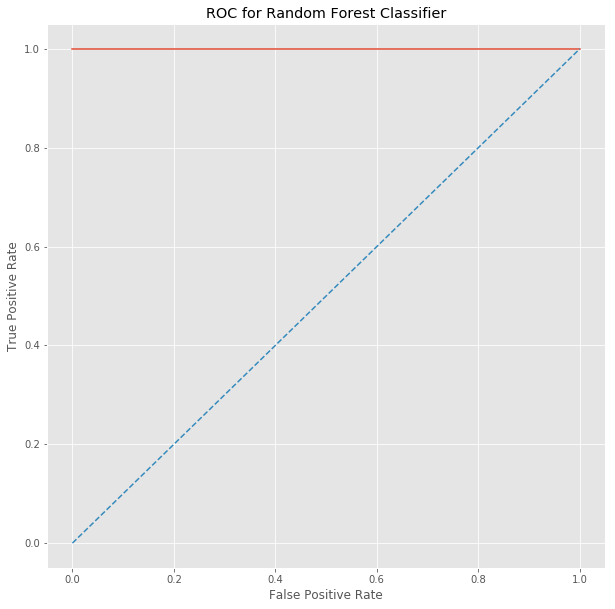

In [32]:
plt.plot(FP, TP, label='AUC = %0.2f'% roc_auc)
plt.title('ROC for Random Forest Classifier')
plt.plot([0,1],[0,1],'--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [33]:
oversampler = SMOTE(random_state=0)
from sklearn.ensemble import RandomForestClassifier
d_pos = df_model[df_model['growth_sign'] == 1]
d_neg = df_model[df_model['growth_sign'] == 0]
d_neg = d_neg
frames = [d_pos, d_neg]
result = pd.concat(frames)
X = result.drop(['growth_sign'], axis = 1)
y = result[['growth_sign']]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)
# Instantiate a Decision Tree classifier: tree

X_train_os,Y_train_os=oversampler.fit_sample(X_train,y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
rf_os = RandomForestClassifier(random_state=0)
rf_os.fit(X_train_os,Y_train_os)

In [ ]:
Y_predict_os=rf_os.predict(X_test)

In [ ]:
confusion_matrix(y_test,Y_predict_os)

In [ ]:
FP, TP, thresholds = roc_curve(y_test,Y_predict_os)
roc_auc = auc(FP, TP)
print (roc_auc)

In [ ]:
plt.plot(FP, TP, label='AUC = %0.2f'% roc_auc)
plt.title('ROC for Random Forest Classifier, with SMOTE')
plt.plot([0,1],[0,1],'--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [35]:
len(df_model)

909